In [1]:
import torch
import numpy as np

import autograd.numpy as np
from autograd import elementwise_grad as egrad  # for functions that vectorize over inputs
from autograd import grad

from scipy.optimize import minimize

from collections import defaultdict
from itertools import zip_longest
from functools import partial

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

### Usefull references:

**Straka's course-page and github**
https://github.com/ufal/npfl114/tree/master/slides/02
http://ufal.mff.cuni.cz/courses/npfl114/1819-summer#home

[**Automatic differentiation wiki**](https://en.wikipedia.org/wiki/Automatic_differentiation)

**After reading the chapter and looking at Straka's and Karpathy's lectures I wanted to generete something like this:**

![SegmentLocal](optimizers_gifs/optimizers_1.gif "segment")

**Came close, unfortunately became bored earlier.**

### Example of automatic differentiation

In [2]:
def plot_diff_up_to_4th(f, x):
    plt.plot(x, f(x),
        x, egrad(f)(x),
        x, egrad(egrad(f))(x),
        x, egrad(egrad(egrad(f)))(x),
        x, egrad(egrad(egrad(egrad(f))))(x))
    plt.grid()
    plt.legend(['f', '1st', '2nd', '3rd', '4th'])

In [3]:
def tanh(x):
    y = np.exp(-2.0 * x)
    return (1.0 - y) / (1.0 + y)

f = tanh
x = np.linspace(-7, 7, 200)

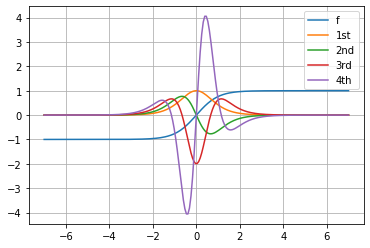

In [4]:
plot_diff_up_to_4th(f, x)

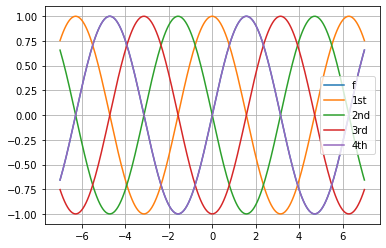

In [5]:

def sin(x):
    return np.sin(x)

x = np.linspace(-7, 7, 200)

f = sin
plot_diff_up_to_4th(f, x)

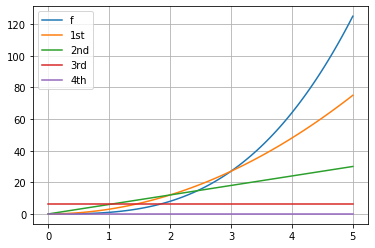

In [6]:
def cubic(x):
    return x**3

x = np.linspace(0, 5,100)

f = cubic 

plot_diff_up_to_4th(f, x)

### Surface, Contour plots and Gradient fields
* [test functions for optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization)



In [97]:
from optim_functions_2d import *

# design through .__name__ attribute of the function
search_domain = {
    'rastrigin': (rastrigin, [-5.12,5.12]),
    'sphere': (sphere,[-4.5, 4.5]),
    'rosen': (rosen, [-3.0, 3.0]),
    'beale': (beale,[-4.5, 4.5]),
    'holder': (holder,[-10.10]),
    'camel': (camel, [-5,5])
    }

def surface_plot(func_name, aux):

    # minima_ = np.array([0,0]).reshape(-1, 1)
    
    ## generate data 
    _ = aux[func_name]
    f = _[0]
    l,h = _[1][0], _[1][1]
    xmin, xmax, xstep = l, h, .2
    ymin, ymax, ystep = l, h, .2
    
    x,y =  np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = f(x,y)
        
    dz_dx = egrad(f, argnum=0)(x, y)
    dz_dy = egrad(f, argnum=1)(x, y)


    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)

    ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                    edgecolor='none', alpha=.8, cmap=plt.cm.jet)

    # ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()

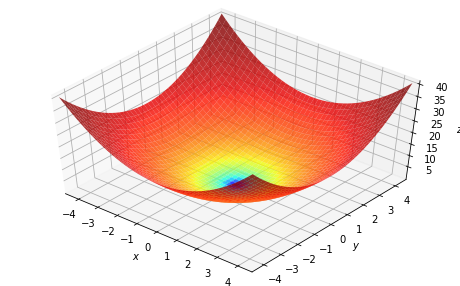

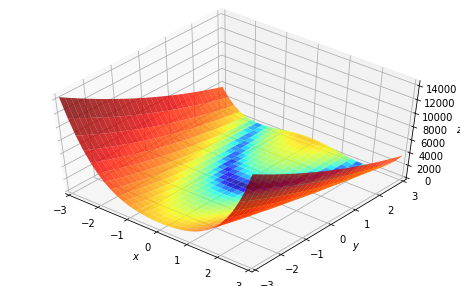

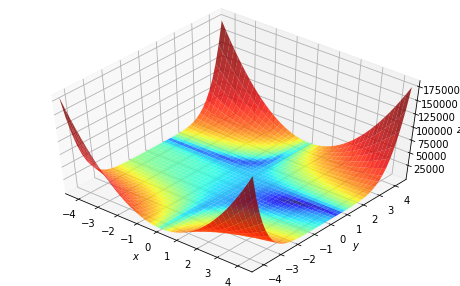

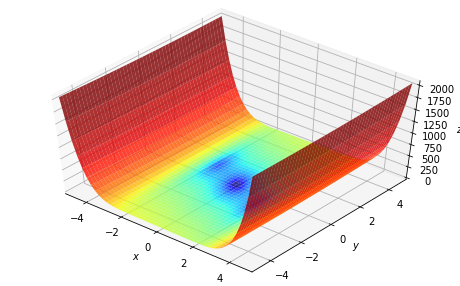

In [99]:
for fc in ['sphere', 'rosen', 'beale', 'camel']:
    surface_plot(fc, search_domain)

In [31]:
def plot_contour(func_name,aux,path = None):
    
    """Plot gradient field."""
    
    # generate data 
    _ = aux[func_name]
    f = _[0]
    l,h = _[1][0], _[1][1]
    xmin, xmax, xstep = l, h, .2
    ymin, ymax, ystep = l, h, .2
    
    x,y =  np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = f(x,y)
        
    dz_dx = egrad(f, argnum=0)(x, y)
    dz_dy = egrad(f, argnum=1)(x, y)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.quiver(x, y, x - dz_dx, y - dz_dy, alpha=.5)
    
    if path is not None:
        ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
    else:
        pass

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()


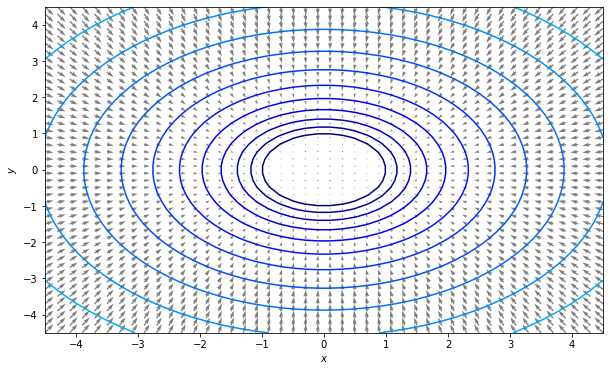

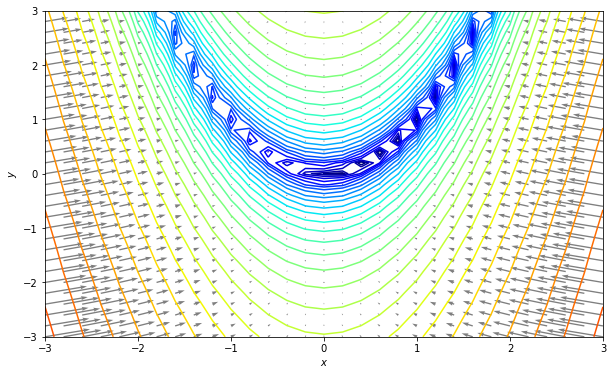

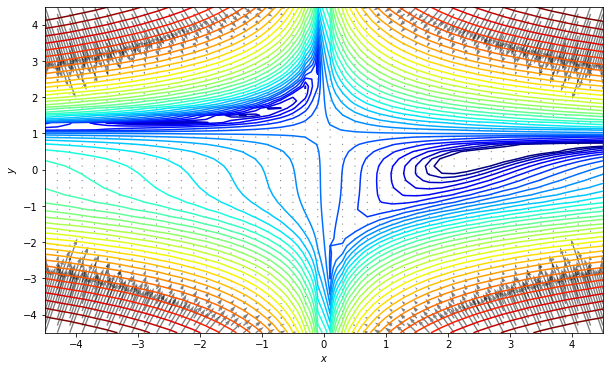

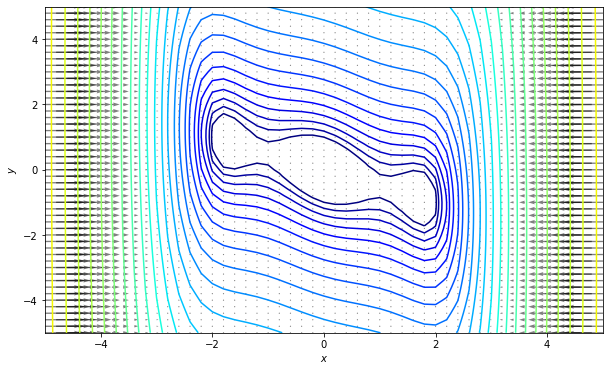

In [32]:
for fc in ['sphere', 'rosen', 'beale', 'camel']:
    plot_contour(fc, search_domain)

# Optimizers

## SGD

In [33]:
# Set how to deal with the under/overflow errors
np.seterr(all='warn', over='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [34]:
def sgd(f,loc = np.array([3.5,3.5]), num_iters = 100, step_size = 0.1, tolerance = 1e-8, momentum = None):
    path_ = [loc]
    velocity = np.array([0,0])
    for i in range(num_iters):
        g1 = egrad(f, argnum=0)(loc[0],loc[1])
        g2 =  egrad(f, argnum=1)(loc[0],loc[1])
        g = np.array([g1,g2]) # np.concatenate([g1,g2])
        
        if momentum == None:
            loc = loc - step_size*g
            path_.append(loc)
            obj_val = beale(loc[0],loc[1])
            # print(loc, obj_val)
            if obj_val < tolerance:
                print('Tolerance met.', obj_val)
                print('Final parameters: ', str(loc))
                break
                
        else: 
            mass = momentum
            velocity = mass * velocity - (1.0 - mass)*g
            loc = loc + step_size*velocity
            path_.append(loc)
            obj_val = beale(loc[0],loc[1])
            # print(loc, obj_val)
            if obj_val < tolerance:
                print('Tolerance met.', obj_val)
                print('Final parameters: ', str(loc))
                break            
                
    path = np.array(path_).T
    return loc, obj_val, path

In [35]:
sgd_path = sgd(sphere, loc = np.array([3.5,3.5]), num_iters = 100, step_size = 0.1, tolerance = 1e-8, momentum = None)[2]

In [36]:
sgdm_path = sgd(sphere, loc = np.array([3.5,3.5]), num_iters = 100, step_size = 0.1, tolerance = 1e-8, momentum = 0.8)[2]

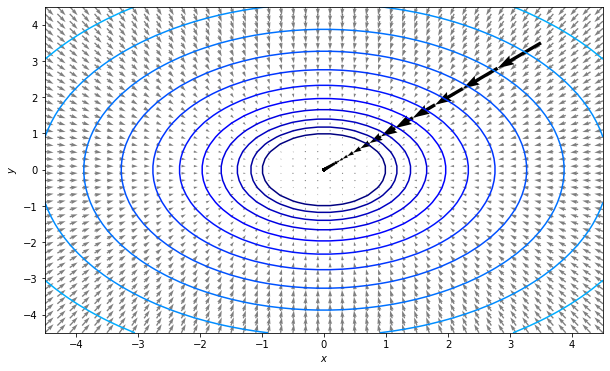

In [37]:
plot_contour(sphere.__name__,search_domain,sgd_path)

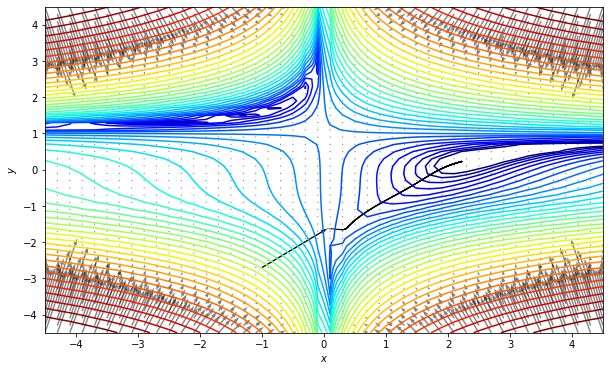

In [191]:
sgd_path = sgd(beale, loc = np.array([-1,-2.7]), num_iters = 1000, step_size = 0.001, tolerance = 1e-8, momentum = None)[2]
plot_contour(beale.__name__,search_domain,sgd_path)

###  Motivation for momentum in SGD

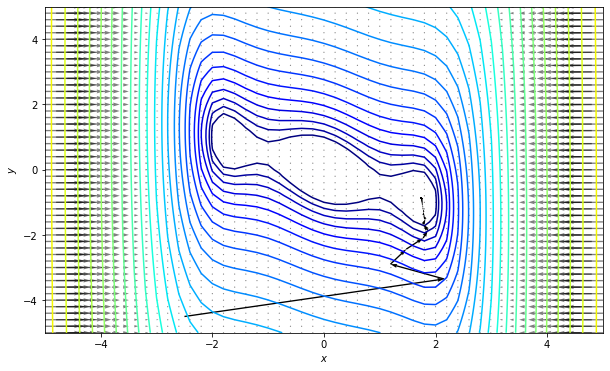

In [111]:
sgd_path = sgd(camel, loc = np.array([-2.5,-4.5]), num_iters = 1000, step_size = 0.1, tolerance = 1e-8, momentum = None)[2]
plot_contour(camel.__name__,search_domain,sgd_path)

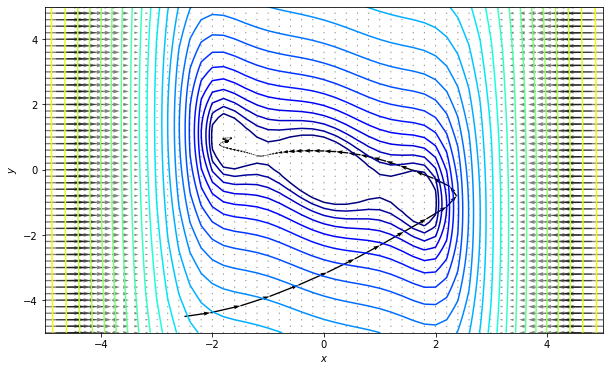

In [115]:
sgdm_path = sgd(camel, loc = np.array([-2.5,-4.5]), num_iters = 1000, step_size = 0.1, tolerance = 1e-8, momentum = 0.9)[2]
plot_contour(camel.__name__,search_domain,sgdm_path)

### Animation fun
* to animate the trajectory of the optimization algorithm using the [FuncAnimation](http://matplotlib.org/api/animation_api.html#matplotlib.animation.FuncAnimation) class
* first, draw the 2D contour plot as we did before, and initialize the `line` and `point` (which are [Line2D](http://matplotlib.org/api/lines_api.html#matplotlib.lines.Line2D) objects)
* guides on how to use the `FuncAnimation` class can be found in tutorials such as [Jake Vanderplas' Matplotlib Animation Tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/)

In [39]:
def generate_video(func_name, aux, path):
    
    # generate data 
    _ = aux[func_name]
    f = _[0]
    l,h = _[1][0], _[1][1]
    xmin, xmax, xstep = l, h, .2
    ymin, ymax, ystep = l, h, .2
    
    x,y =  np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = f(x,y)
        
    dz_dx = egrad(f, argnum=0)(x, y)
    dz_dy = egrad(f, argnum=1)(x, y)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    # ax.plot(*minima_, 'r*', markersize=18)

    line, = ax.plot([], [], 'b', label='SGD', lw=2)
    point, = ax.plot([], [], 'bo')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    def init():
        line.set_data([], [])
        point.set_data([], [])
        return line, point

    def animate(i):
        line.set_data(*path[::,:i])
        point.set_data(*path[::,i-1:i])
        return line, point

    return animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=path.shape[1], interval=60, 
                                   repeat_delay=5, blit=True)

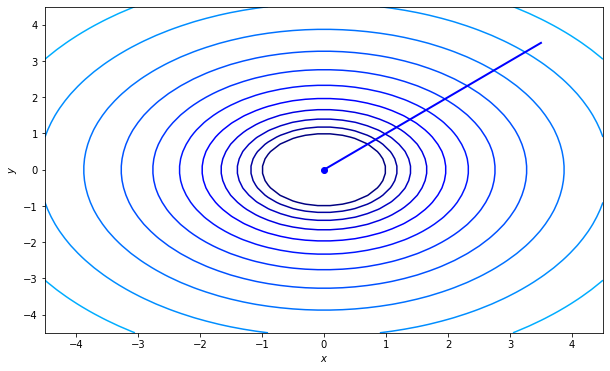

In [40]:
vid = generate_video(sphere.__name__, search_domain, sgd_path).to_html5_video()

In [41]:
HTML(vid)

## Algorithm with Adaptive Learning Rates

* the learning rate as one of the most difficult ot set hyperparameters (significantly affects model performance)
    * adding momentum helps but at the cost of additional hyperparameter
* the **delta-bar-delta** algorithm: an early heuristic approah to adapting individual learning rates for model parameters during training
    * if the partial derivative of the loss, with respect
    to a given model parameter, remains the same sign, then the learning rate should
    increase
    * if that partial derivative changes sign, then the learning rate should
    decrease
    * applies only to full batch optimization
## AdaGrad
* individually adapts the learning
rates of all model parameters by scaling them inversely proportional to the square
root of the sum of all the historical squared values of the gradient
* requires:
    * $\epsilon$ (global learning rate)
    * $\delta$ (small constant ~$10^-7$ for numerical stability)

$r = 0$ - init. gradient accumulation variable

While stopping criterion not met:

1. $\{x^{(1)}, \dots, x^{(m)} \}$ and $\{y^{(1)}, \dots, y^{(m)} \}$ - sample a minibatch
2. $g = \frac{1}{m}\nabla_{\theta}\sum_i L(f(x^{(i)};\theta),y^{(i)})$ - compute gradient
3. $r = r + g \odot g$ - accumulate squared gradient (notice the hadamard product)
4.  $\Delta \theta = -\frac{\epsilon}{\delta + \sqrt{r}}\odot g$ - again elementwise
5.  $\theta \leftarrow \theta + \Delta \theta$- update

In [145]:
def adagrad(f,loc = np.array([3.5,3.5]), num_iters = 100, step_size = 0.1, tolerance = 1e-8, eps=10**-8):
    path_ = [loc]
    avg_sq_grad = np.array([1,1])
    for i in range(num_iters):
        g1 = egrad(f, argnum=0)(loc[0],loc[1])
        g2 =  egrad(f, argnum=1)(loc[0],loc[1])
        g = np.array([g1,g2]) # np.concatenate([g1,g2])
        avg_sq_grad = avg_sq_grad + g**2 
        loc = loc - step_size*g/(np.sqrt(avg_sq_grad) + eps)
        path_.append(loc)
        obj_val = beale(loc[0],loc[1])
        # print(loc, obj_val)
        if obj_val < tolerance:
            print('Tolerance met.', obj_val)
            print('Final parameters: ', str(loc))
            break
                
    path = np.array(path_).T
    return loc, obj_val, path

In [143]:
adagrad_path = adagrad(camel,loc = np.array([-2.5,-4.5]),
                       num_iters = 1000, step_size = 0.3, tolerance = 1e-8, eps=10**-8)[2]

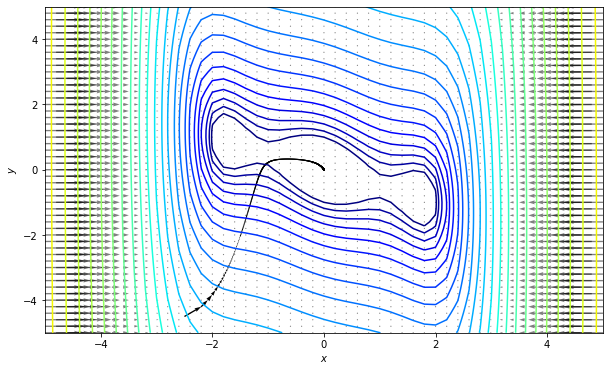

In [144]:
plot_contour(camel.__name__,search_domain,adagrad_path)

## RMS Prop

* by Hinton (2012)
* modifies AdaGrad to perform better in the nonconvex setting
    * changes the gradient accumulation into an exponentially weighted moving average
    * discard history from the extreme past so that it can converge rapidly after ﬁnding a convex bowl
        *  as if it were an instance of the AdaGrad algorithm initialized within that bowl
* requires:
    * $\epsilon$ (global learning rate)
    * $\rho$ (decay rate)
    * $\delta$ (small constant ~$10^-6$ used to stabilize division by small numbers)

$r = 0$ - init. gradient accumulation variable

While stopping criterion not met:

1. $\{x^{(1)}, \dots, x^{(m)} \}$ and $\{y^{(1)}, \dots, y^{(m)} \}$ - sample a minibatch
2. $g = \frac{1}{m}\nabla_{\theta}\sum_i L(f(x^{(i)};\theta),y^{(i)})$ - compute gradient
3. $r = \rho r + (1-\rho)g \odot g$ - accumulate squared gradient (notice the hadamard product)
4.  $\Delta \theta = -\frac{\epsilon}{\delta + \sqrt{r}}\odot g$ - again elementwise
5.  $\theta \leftarrow \theta + \Delta \theta$ - update

* can be combined with Nesterov momentum
    * just adding momentum coefficient $\alpha$

In [43]:
def rmsprop(f,loc = np.array([3.5,3.5]), num_iters = 100, step_size = 0.1, tolerance = 1e-8, gamma=0.9, eps=10**-8):
    path_ = [loc]
    
    avg_sq_grad = np.array([1,1])
    for i in range(num_iters):
        g1 = egrad(f, argnum=0)(loc[0],loc[1])
        g2 =  egrad(f, argnum=1)(loc[0],loc[1])
        g = np.array([g1,g2]) 
        avg_sq_grad = avg_sq_grad * gamma + g**2 * (1 - gamma)
        loc = loc - step_size*g/(np.sqrt(avg_sq_grad) + eps)
        path_.append(loc)
        obj_val = beale(loc[0],loc[1])
        # print(loc, obj_val)
        if obj_val < tolerance:
            print('Tolerance met.', obj_val)
            print('Final parameters: ', str(loc))
            break
                
    path = np.array(path_).T
    return loc, obj_val, path

In [170]:
rmsprop_path = rmsprop(camel,loc = np.array([-2.5,-4.5]), num_iters = 100, step_size = 0.1, tolerance = 1e-8, gamma=0.9, eps=10**-8)[2]

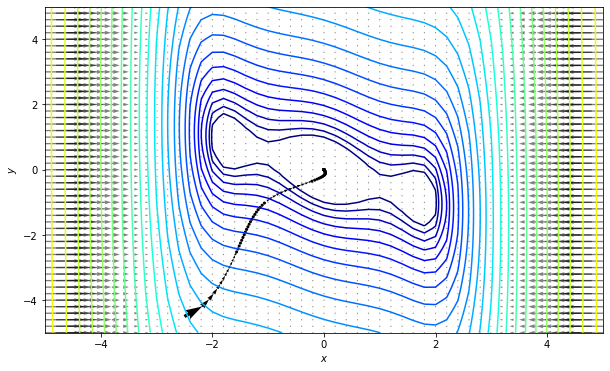

In [171]:
plot_contour(camel.__name__, search_domain, rmsprop_path)

## Adam

* "ADAptive Moments"
* by Kingma and Ba (2014)
* a variant on the combination of RMSProp and momentum with a few important distinctions
    * **momentum** incorporated directly **as an estimate of the first-order moment** (with exponential weighting) of **the gradient**
    * includes **bias corrections** to the estimates of 
        * **the first-order moments** (the momentum term)
        * **the (uncentered) second-order moments** 
        
        ... to account for their initialization at the origin

* requires:
    * step size ($\epsilon$)
    * exponential decay rates for moment estimates
        * $\rho_1$ and $\rho_2$  in $[0,1)$ (Suggested defaults: 0.9 and 0.999 respectively) 
    * $\delta$ (small constant ~$10^{-8}$

$s = 0$ and $r = 0$ - init. 1st and 2nd moment variables
$t = 0$ - init time step    
While stopping criterion not met:

1. $\{x^{(1)}, \dots, x^{(m)} \}$ and $\{y^{(1)}, \dots, y^{(m)} \}$ - sample a minibatch
2. $g = \frac{1}{m}\nabla_{\theta}\sum_i L(f(x^{(i)};\theta),y^{(i)})$ - compute gradient
3. $t \leftarrow t + 1$ 
4. $s \leftarrow  \rho_1 s + (1-\rho_1)g$ - update biased ﬁrst moment estimate
5. $r \leftarrow  \rho_2 r + (1-\rho_2) g \odot g$ - update biased second moment estimate
6. $\hat{s} \leftarrow \frac{s}{1-\rho_1^t} $ and $\hat{r} \leftarrow \frac{r}{1-\rho_2^t} $  - correct biases in the first and second moments
4.  $\Delta \theta = -\epsilon\frac{\hat{s}}{\sqrt{\hat{r}} + \delta}$ - again elementwise
5.  $\theta \leftarrow \theta + \Delta \theta$ - update

* RMSProp also incorporates an estimate of the second-order moment; however, it lacks the correction factor
* logic for the correction factor:


After $t$ steps:
$$r_t = (1-\beta_2)\sum_{i=1}^t\beta_2^{t-i}g_i^2$$

    * may have high bias in second-order moment estimate early in the trainning
* considered as robust ot the choice of hyperparameters


**Which algorithm to choose?**
* no consensus
* Schaul et al. (2014) - horserace
    * algos with adaptive learning rates have robust performance but not best

In [46]:
def adam(f,loc = np.array([3.5,3.5]), num_iters = 100, step_size = 0.1, tolerance = 1e-8, b1=0.9 , b2=0.999 , eps=10**-8, m = 0 , v = 0):
    
    path_ = [loc]
    avg_sq_grad = np.array([1,1])
    for i in range(num_iters):
        g1 = egrad(f, argnum=0)(loc[0],loc[1])
        g2 =  egrad(f, argnum=1)(loc[0],loc[1])
        g = np.array([g1,g2])
        m = (1 - b1) * g + b1 * m # 1st  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # 2nd moment estimate.
        # Bias corrections
        mhat = m / (1 - b1**(i + 1)) 
        vhat = v / (1 - b2**(i + 1))
        loc = loc - step_size*mhat/(np.sqrt(vhat) + eps)
        path_.append(loc)
        obj_val = beale(loc[0],loc[1])
        # print(loc, obj_val)
        if obj_val < tolerance:
            print('Tolerance met.', obj_val)
            print('Final parameters: ', str(loc))
            break
                
    path = np.array(path_).T
    return loc, obj_val, path

In [166]:
adam_path = adam(camel,loc = np.array([-2.5,-4.5]), num_iters = 200, step_size = 0.4, tolerance = 1e-8, b1=0.9 , b2=0.999 , eps=10**-8, m = 0 , v = 0)[2]

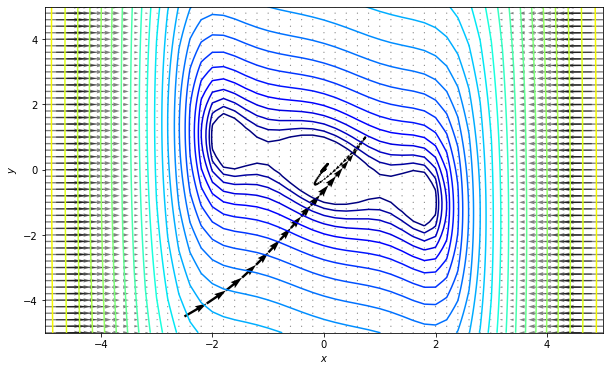

In [167]:
plot_contour(camel.__name__, search_domain, adam_path)

## 8.6 Approximate Second-Order Methods

*  second-order methods make use of second derivatives

### Newton's Method

* the most widely used second-order method
* **problematic for trainning NNs**
    * the signiﬁcant computational burden
* uses a second-order Taylor series expansion to approximate $J(\theta)$ near some point $\theta_0$  (ignoring derivatives of higher order)

$$J(\theta) \approx J(\theta_0) + (\theta - \theta_0)^T \nabla_{\theta}J(\theta_0) + \frac{1}{2}(\theta - \theta_0)^T H(\theta - \theta_0)$$

* solve for the critical point of this function to obtain **the Newton parameter update rule**:
    $$\theta^* = \theta_0 - H^{-1}\nabla_{\theta}J(\theta_0)$$


* in DL, the surface of the objective function is typically nonconvex (with saddle points)
    * if the eigenvalues of the Hessian are notall positive (e.g. near a saddle point) then Newton’s method can move in the wrong direction
        * can be avoided by regularizing the Hessian (e.g. adding $\alpha$ along the diagonal)

$$\theta^* = \theta_0 - [H(f(\theta_0)) + \alpha I]^{-1}\nabla_{\theta} f(\theta_0)$$
        * works fairly well as long as the negative eigenvalues of the Hessian are still relativelyclose to zero
        * As $\alpha$ increases in size -> the Hessian becomes dominated by the $\alpha I$ diagonal $\rightarrow$ converges to the standard gradient divided by $\alpha$
* computationally difficult (because of the Hessian)
    * inversion of $k\times k$ matrix $\rightarrow$ $O(k^3)$ complexity
    * computed at every training iteration

In [49]:
# scipy-related imports
from autograd import value_and_grad

def logger(path=[]):
    """ Callback function logging coordinates as we iterate. """
    def log_(xk):
        path.append(np.copy(xk))
    return log_

In [50]:
f = sphere
func = value_and_grad(lambda args: f(*args))
x0 = np.array([3., 4.]) # ex. of unsuccesfull np.array([0.5,2])
path_ = [x0]
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=logger(path_)) # callback=print
ncg_path = np.array(path_).T

dict(res)

{'fun': 0.0,
 'jac': array([0., 0.]),
 'nfev': 3,
 'njev': 6,
 'nhev': 0,
 'status': 0,
 'success': True,
 'message': 'Optimization terminated successfully.',
 'x': array([0., 0.]),
 'nit': 2}

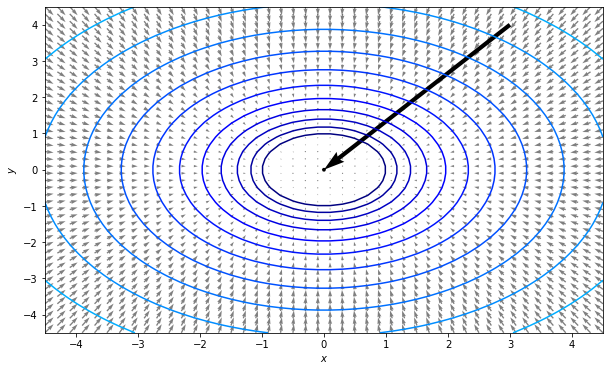

In [146]:
plot_contour(sphere.__name__, search_domain, ncg_path)

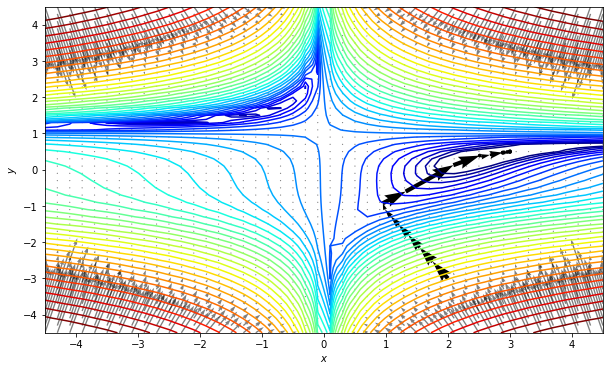

In [197]:
f = beale
func = value_and_grad(lambda args: f(*args))
x0 = np.array([2, -3]) # vs. np.array([-3, 4.])
path_ = [x0]
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=logger(path_)) # callback=print
ncg_path = np.array(path_).T

plot_contour(beale.__name__, search_domain, ncg_path)

### Conjugate Gradients (CG)

* method to avoid the calculation of the inverse Hessian by **iteratively descending conjugate directions**
    * based on the weakness of the method of the GD
    * when GD applied in a quadratic bowl, progresses in a back-and-forth zig-zag pattern
        * because each line search direction,when given by the gradient, is guaranteed to be orthogonal to the previous linesearch direction
        * by following the gradient atthe end of each line search we are, in a sense, undoing progress we have already made in the direction of the previous line search

* in CG,  seek to ﬁnd a search direction that isconjugateto the previous line search direction; that is, it will not undo progressmade in that direction
$$d_t = \nabla_{\theta} J(\theta) + \beta_t d_{t-1}$$
where $d_{t-1}$ is the previous search direction and $\beta_t$ controls how much of the direction $dt−1$ we should add back to the current search direction

* two directions $d_t$ and $d_{t-1}$ are conjugate if $d_t^THd_{t-1} = 0$

* how to impose conjugacy?
    * calculation of the eigenvectors of $H$ to choose $\beta_t$ $\rightarrow$ this would not speed things up
    * alternatives (just for reference):
        * Fletcher-Reeves
        * Polak-Ribiere

In [147]:
f = rosen
func = value_and_grad(lambda args: f(*args))
x0 = np.array([-2., 2.]) # ex. of unsuccesfull np.array([0.5,2])
path_ = [x0]
res = minimize(func, x0=x0, method='CG',
               jac=True, tol=1e-20, callback=logger(path_)) # callback=print
cg_path = np.array(path_).T

dict(res)

{'fun': 1.7749370367472766e-30,
 'jac': array([2.66453526e-15, 0.00000000e+00]),
 'nfev': 281,
 'njev': 269,
 'status': 2,
 'success': False,
 'message': 'Desired error not necessarily achieved due to precision loss.',
 'x': array([1., 1.]),
 'nit': 47}

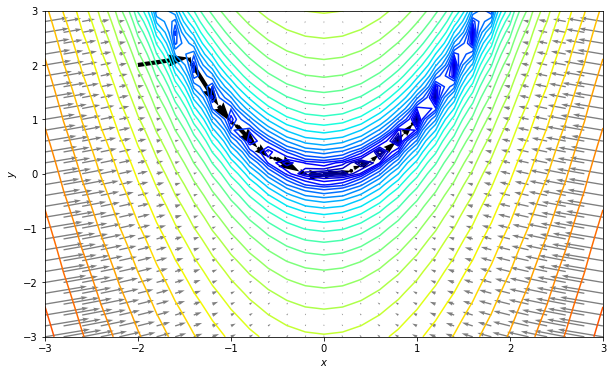

In [148]:
plot_contour(rosen.__name__, search_domain,cg_path)

### BFGS (Broyden-Fletcher-Goldfarb-Shanno) algorithm
* example of a quasi-Newton method
* bring advantages of Newton's method without the computational burder
* similar to the CG method, with more direct approximation of the Newton's update
    * main problem: inversion of the H
* approximate the inverse with a matrix $M_t$ that is iteratively reﬁned by low-rank updates to become a better approximation of $H^{−1}$ 

* once the $M_t$ is updated, the direction of descent is $\rho_t = M_t g_t$
    * a line search is performed in this direction to determine the size of the step $\epsilon^*$, taken in this direction
* the final update: $\theta_{t+1} = \theta_t + \epsilon^*\rho_t$

*  relative to conjugate gradients, BFGS has the advantage that it can spendless ti|me reﬁning each line search
* On the other hand, the BFGS algorithm must store the inverse Hessian matrix, M, that requires $O(n^2)$ memory, making BFGS impractical for most modern deep learning models that typically have millions ofparameters

In [54]:
f = beale
func = value_and_grad(lambda args: f(*args))
x0 = np.array([-2., -3.]) # ex. of unsuccesfull np.array([0.5,2])
path_ = [x0]
res = minimize(func, x0=x0, method='BFGS',
               jac=True, tol=1e-20, callback=logger(path_)) # callback=print
bfgs_path= np.array(path_).T

dict(res)

{'fun': 7.314546905196723,
 'jac': array([-8.55469714e+08,  6.36515458e-06]),
 'hess_inv': array([[1.25209902e-20, 1.74874278e-06],
        [1.74874278e-06, 2.44624426e+08]]),
 'nfev': 527,
 'njev': 527,
 'status': 1,
 'success': False,
 'message': 'Maximum number of iterations has been exceeded.',
 'x': array([ 1.35509239e-11, -5.78420108e+03]),
 'nit': 400}

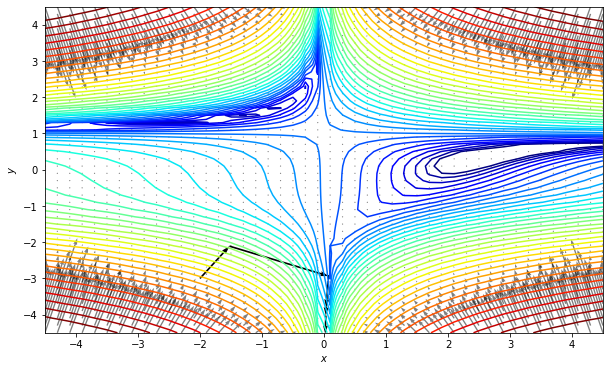

In [55]:
plot_contour(beale.__name__, search_domain, bfgs_path)

In [56]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0]
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)
    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [180]:


methods = [
    "CG",
    "BFGS",
    "Newton-CG",
    "L-BFGS-B",
    "TNC",
    "SLSQP",
]

f = camel
func = value_and_grad(lambda args: f(*args))
x0 = np.array([3., 4.])

minimize_ = partial(minimize, fun=func, x0=x0, jac=True, tol=1e-20) # bounds=[(xmin, xmax), (ymin, ymax)]
paths_ = defaultdict(list)
for method in methods:
    paths_[method].append(x0)
    
results = {method: minimize_(method=method, callback=logger(paths_[method])) for method in methods}

paths = [np.array(paths_[method]).T for method in methods]

sgd_path = sgd(sphere, loc = np.array([3.5,3.5]), num_iters = 200, step_size = 0.1, tolerance = 1e-8, momentum = None)[2]
adam_path = adam(beale,loc = np.array([3.5,3.5]), num_iters = 200, step_size = 0.4, tolerance = 1e-8, b1=0.9 , b2=0.999 , eps=10**-8, m = 0 , v = 0)[2]

# append ML-based optim paths
paths.append(sgd_path)
paths.append(adam_path)

zpaths = [f(*path).T for path in paths]
zpaths.append([f(*sgd_path)]) #p_sgdm,p_adam
zpaths.append([f(*adam_path)])
methods.append('sgd')
methods.append('adam')

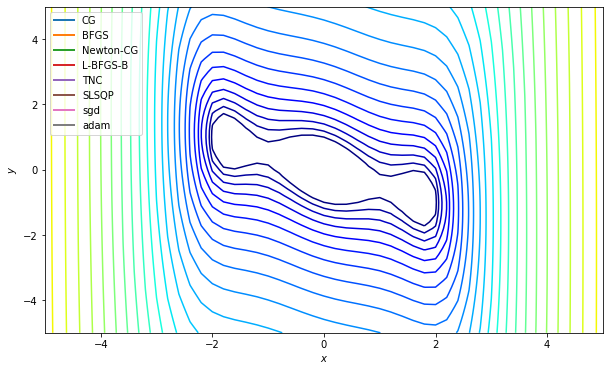

In [182]:
func_name = 'camel'
_ = search_domain[func_name]
f = _[0]
l,h = _[1][0], _[1][1]
xmin, xmax, xstep = l, h, .2
ymin, ymax, ystep = l, h, .2
x,y =  np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x,y)

fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
# ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [183]:
HTML(anim.to_html5_video())

Can you see the logic in the typical following animations?

![SegmentLocal](optimizers_gifs/optimizers_1.gif "segment")

![SegmentLocal](optimizers_gifs/optimizers_2.gif "segment")

![SegmentLocal](optimizers_gifs/optimizers_3.gif "segment")

![SegmentLocal](optimizers_gifs/optimizers_4.gif "segment")

## 8.7 Optimization Strategies and Meta-Algorithms (just briefly)

* Batch Normalization
* Coordinate Descent
* Polyak Averaging
* Supervised Pretraining
* Designing Models to Aid Optimization
* Continuation Methods and Curriculum Learning